In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os

files = os.listdir('../SinCosDataset/')

print("Avaiable files:", '\n\t\t'.join(files))

data = {}
for el in files:
    data[el] = pd.read_csv(f'../SinCosDataset/{el}', sep=' ', header=None)
    data[el].columns = [f'f{i+1}' for i in range(len(data[el].columns))]

Avaiable files: datale33.txt
		datale7.txt
		datale22.txt
		datale6.txt
		datale1.txt
		datale11.txt
		data_sin1.txt
		datale2.txt
		datale5.txt
		datale.txt
		data_sin.txt
		datale4.txt
		datale3.txt


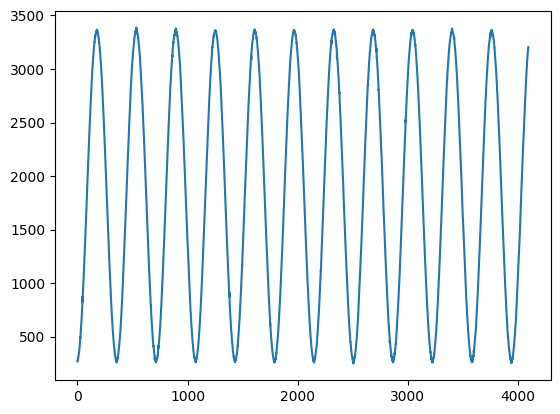

0        268
1        276
2        275
3        277
4        284
        ... 
4091    3171
4092    3171
4093    3178
4094    3199
4095    3205
Name: f2, Length: 4096, dtype: int64

In [16]:

plt.plot(data['data_sin.txt']['f2'])
plt.show()
data['data_sin.txt']['f2']